In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Manually Implementing an LSTM Cell

In [16]:
# Define the input and hidden dimensions
n_features = 2
hidden_dim = 2

In [17]:
# Initialize the LSTM cell
torch.manual_seed(17)
lstm_cell = nn.LSTMCell(input_size=n_features, hidden_size=hidden_dim)
lstm_state = lstm_cell.state_dict()
lstm_state

OrderedDict([('weight_ih',
              tensor([[-0.0930,  0.0497],
                      [ 0.4670, -0.5319],
                      [-0.6656,  0.0699],
                      [-0.1662,  0.0654],
                      [-0.0449, -0.6828],
                      [-0.6769, -0.1889],
                      [-0.4167, -0.4352],
                      [-0.2060, -0.3989]])),
             ('weight_hh',
              tensor([[-0.7070, -0.5083],
                      [ 0.1418,  0.0930],
                      [-0.5729, -0.5700],
                      [-0.1818, -0.6691],
                      [-0.4316,  0.4019],
                      [ 0.1222, -0.4647],
                      [-0.5578,  0.4493],
                      [-0.6800,  0.4422]])),
             ('bias_ih',
              tensor([-0.3559, -0.0279,  0.6553,  0.2918,  0.4007,  0.3262, -0.0778, -0.3002])),
             ('bias_hh',
              tensor([-0.3991, -0.3200,  0.3483, -0.2604, -0.1582,  0.5558,  0.5761, -0.3919]))])

In [18]:
Wx, bx = lstm_state['weight_ih'], lstm_state['bias_ih']
Wh, bh = lstm_state['weight_hh'], lstm_state['bias_hh']

In [19]:
# input gate(i), forget gate (f), cell candidate (g), and output gate (o).
Wxi, Wxf, Wxg, Wxo = Wx.split(hidden_dim, dim=0)
bxi, bxf, bxg, bxo = bx.split(hidden_dim, dim=0)
Whi, Whf, Whg, Who = Wh.split(hidden_dim, dim=0)
bhi, bhf, bhg, bho = bh.split(hidden_dim, dim=0)

In [20]:
# Define a helper function to create linear layers
def linear_layers(Wx, bx, Wh, bh):
    hidden_dim, n_features = Wx.size()
    lin_input = nn.Linear(n_features, hidden_dim)
    lin_input.load_state_dict({'weight': Wx, 'bias': bx})
    lin_hidden = nn.Linear(hidden_dim, hidden_dim)
    lin_hidden.load_state_dict({'weight': Wh, 'bias': bh})
    return lin_hidden, lin_input

In [21]:
# Create linear layers for each gate and the candidate cell state
i_hidden, i_input = linear_layers(Wxi, bxi, Whi, bhi)  # Input gate
f_hidden, f_input = linear_layers(Wxf, bxf, Whf, bhf)  # Forget gate
o_hidden, o_input = linear_layers(Wxo, bxo, Who, bho)  # Output gate

In [22]:
# Create an RNN cell for the candidate hidden state (g)
g_cell = nn.RNNCell(n_features, hidden_dim)  # Candidate hidden state
g_cell.load_state_dict({'weight_ih': Wxg, 'bias_ih': bxg, 'weight_hh': Whg, 'bias_hh': bhg})

<All keys matched successfully>

In [23]:
# Define gate functions
def input_gate(h, x):
    thi = i_hidden(h)
    txi = i_input(x)
    i = torch.sigmoid(thi + txi)
    return i

def forget_gate(h, x):
    thf = f_hidden(h)
    txf = f_input(x)
    f = torch.sigmoid(thf + txf)
    return f

def output_gate(h, x):
    tho = o_hidden(h)
    txo = o_input(x)
    o = torch.sigmoid(tho + txo)
    return o

In [24]:
# Initial hidden state and cell state
initial_hidden = torch.zeros(1, hidden_dim)
initial_cell = torch.zeros(1, hidden_dim)

In [25]:
X = torch.tensor([[0.1, 0.2]], dtype=torch.float32)

# Compute candidate hidden state (g)
g = g_cell(X, initial_hidden)

# Compute gates
i = input_gate(initial_hidden, X)
f = forget_gate(initial_hidden, X)
o = output_gate(initial_hidden, X)

# Compute new cell state
c_prime = (f * initial_cell) + (i * g)

# Compute new hidden state
h_prime = o * torch.tanh(c_prime)

print(f"Candidate hidden state (g): {g}")
print(f"Input gate (i): {i}")
print(f"Forget gate (f): {f}")
print(f"Output gate (o): {o}")
print(f"New cell state (c'): {c_prime}")
print(f"New hidden state (h'): {h_prime}")

# Verify with PyTorch LSTM cell
lstm_out = lstm_cell(X, (initial_hidden, initial_cell))
print(f"LSTM cell output (hidden state, cell state): {lstm_out}")

Candidate hidden state (g): tensor([[0.1011, 0.6507]], grad_fn=<TanhBackward0>)
Input gate (i): tensor([[0.3199, 0.3995]], grad_fn=<SigmoidBackward0>)
Forget gate (f): tensor([[0.7213, 0.5070]], grad_fn=<SigmoidBackward0>)
Output gate (o): tensor([[0.5914, 0.3116]], grad_fn=<SigmoidBackward0>)
New cell state (c'): tensor([[0.0323, 0.2600]], grad_fn=<AddBackward0>)
New hidden state (h'): tensor([[0.0191, 0.0792]], grad_fn=<MulBackward0>)
LSTM cell output (hidden state, cell state): (tensor([[0.0191, 0.0792]], grad_fn=<MulBackward0>), tensor([[0.0323, 0.2600]], grad_fn=<AddBackward0>))


# LSTM Model

In [26]:
# Generate synthetic data
def generate_sequences(seed):
    torch.manual_seed(seed)
    points = torch.randn(100, 4, 2)  # 100 sequences, each with 4 points (x, y)
    directions = torch.randint(0, 2, (100,))  # 100 labels (0 or 1)
    return points, directions

In [27]:
train_points, train_directions = generate_sequences(seed=19)
test_points, test_directions = generate_sequences(seed=42)

# Prepare data loaders
train_data = TensorDataset(torch.as_tensor(train_points).float(), torch.as_tensor(train_directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(), torch.as_tensor(test_directions).view(-1, 1).float())

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [28]:
# Define the model using an LSTM
class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        
        # LSTM layer
        self.lstm = nn.LSTM(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)

    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        batch_first_output, (hn, cn) = self.lstm(X)
        
        # Only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1, :]
        
        # Classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # Final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [29]:
# Model instance
torch.manual_seed(21)
model = LSTMModel(n_features=2, hidden_dim=2, n_outputs=1)

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [30]:
# Training function
def train(model, train_loader, loss_fn, optimizer, epochs=10):
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        print(f'Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}')
        
        val_loss, _ = evaluate(model, test_loader, loss_fn)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [31]:
# Evaluation function
def evaluate(model, test_loader, loss_fn):
    model.eval()
    epoch_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            epoch_val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = epoch_val_loss / len(test_loader)
    accuracy = correct / total
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
    return avg_val_loss, accuracy

In [35]:
# Train and evaluate the model
epochs=100
train_losses, val_losses = train(model, train_loader, loss_fn, optimizer, epochs=epochs)

Epoch 1, Loss: 0.4249
Validation Loss: 0.9904, Accuracy: 48.00%
Epoch 2, Loss: 0.4294
Validation Loss: 0.9940, Accuracy: 46.00%
Epoch 3, Loss: 0.4010
Validation Loss: 0.9989, Accuracy: 46.00%
Epoch 4, Loss: 0.4423
Validation Loss: 0.9947, Accuracy: 46.00%
Epoch 5, Loss: 0.4258
Validation Loss: 1.0190, Accuracy: 46.00%
Epoch 6, Loss: 0.3990
Validation Loss: 1.0271, Accuracy: 47.00%
Epoch 7, Loss: 0.4416
Validation Loss: 1.0215, Accuracy: 45.00%
Epoch 8, Loss: 0.4151
Validation Loss: 1.0141, Accuracy: 46.00%
Epoch 9, Loss: 0.4768
Validation Loss: 1.0101, Accuracy: 47.00%
Epoch 10, Loss: 0.3871
Validation Loss: 1.0141, Accuracy: 46.00%
Epoch 11, Loss: 0.4357
Validation Loss: 1.0135, Accuracy: 46.00%
Epoch 12, Loss: 0.4629
Validation Loss: 1.0109, Accuracy: 46.00%
Epoch 13, Loss: 0.4100
Validation Loss: 1.0134, Accuracy: 44.00%
Epoch 14, Loss: 0.4417
Validation Loss: 1.0101, Accuracy: 45.00%
Epoch 15, Loss: 0.3823
Validation Loss: 1.0034, Accuracy: 46.00%
Epoch 16, Loss: 0.4017
Validation 

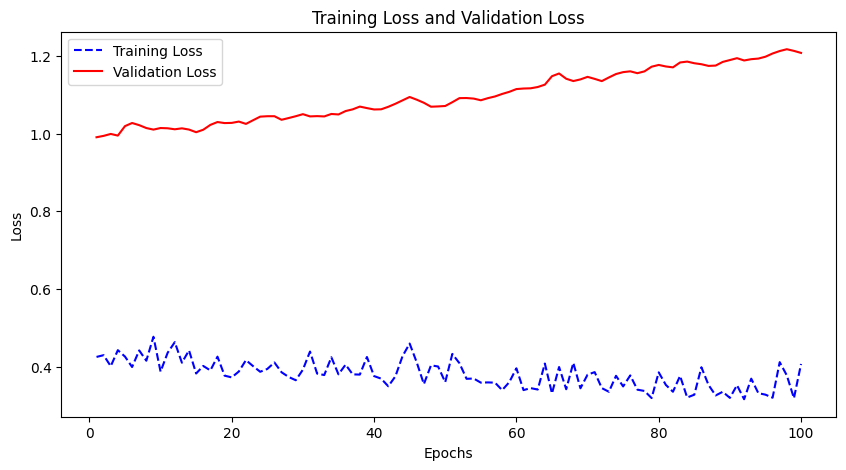

In [36]:
# Ensure both lists have the same length for plotting
assert len(train_losses) == len(val_losses), "Train and validation loss lists must be of the same length"

# Plotting training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', linestyle='--', color='b')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', linestyle='-', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Loss')
plt.legend()
plt.show()

In [37]:
def predict(model, input_sequence):
    model.eval()
    with torch.no_grad():
        output = model(input_sequence)
        prediction = torch.sigmoid(output).item()  # Convert logits to probability
        return prediction

In [38]:
example_sequence = torch.tensor([[[0.1, 0.2], [0.3, 0.4], [0.5, 0.6], [0.7, 0.8]]], dtype=torch.float32)
predicted_label = predict(model, example_sequence)
print(f'Predicted Label: {predicted_label:.4f}')

Predicted Label: 0.9170
